# Explain

### LIME

In [59]:
import lime
import lime.lime_tabular
import numpy as np
from keras.models import load_model
classModel = load_model("classifier.h5")
kddCupTrain = pickle.load(open('prepared_kddCupTrain.sav', 'rb'))
kddCupTest = pickle.load(open('prepared_kddCupTest.sav', 'rb'))

In [75]:
# Drop the class column
X_train_features = kddCupTrain.drop(columns=['Class']).values
X_test_features = kddCupTest.drop(columns=['Class']).values
featuresList = [col for col in kddCupTrain if col != 'Class']

157/157 [==============================] - 0s 1ms/step


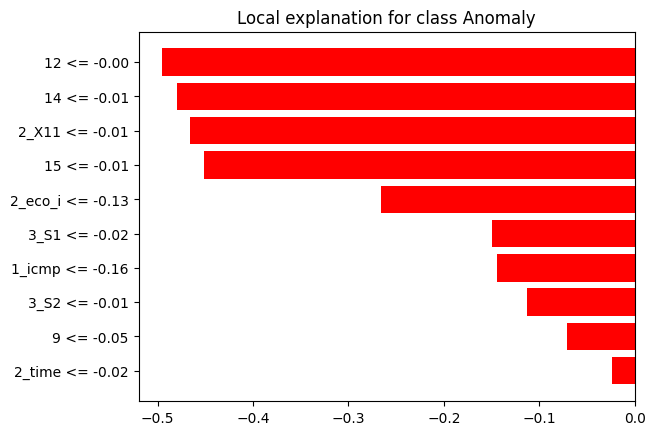

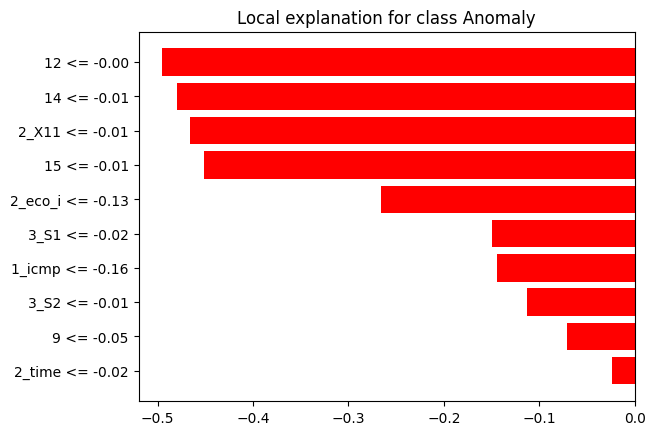

In [81]:
def predict_proba(X):
    preds = classModel.predict(X)
    return np.hstack((1 - preds, preds))  # Ensure it's in two-column format for binary classification

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_features,
    feature_names=featuresList,  # Correct feature names list
    class_names=['Normal', 'Anomaly'],  # Modify according to your class names
    mode='classification'
)

i = 0  # Index of the instance to explain
exp = explainer.explain_instance(
    data_row=X_test_features[i],
    predict_fn=predict_proba,
    num_features=10  # Number of features to show in the explanation
)

# Display the explanation
exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()

The bar chart uses LIME to interpret the model's predictions for the "Anomaly" class. In this case, LIME has identified the features contributing most to the classification as an Normal, since all bar with negative value.

### SHAP

In [ ]:
!pip install shap


In [ ]:
from keras.models import load_model
classModel = load_model("classifier.h5")
kddCupTrain = pickle.load(open('prepared_kddCupTrain.sav', 'rb'))
kddCupTest = pickle.load(open('prepared_kddCupTest.sav', 'rb'))
X_test_adjusted = kddCupTest[:, :83]

In [ ]:
import numpy as np

# Randomly select 100 samples from X_test_adjusted
sample_indices = np.random.choice(X_test_adjusted.shape[0], 100, replace=False)
X_test_sample = X_test_adjusted[sample_indices]


In [ ]:
import shap
import matplotlib.pyplot as plt

masker = shap.maskers.Independent(X_test_sample)
explainer = shap.Explainer(classModel, masker)
shap_values = explainer(X_test_sample)


PermutationExplainer explainer: 101it [00:16,  2.11it/s]


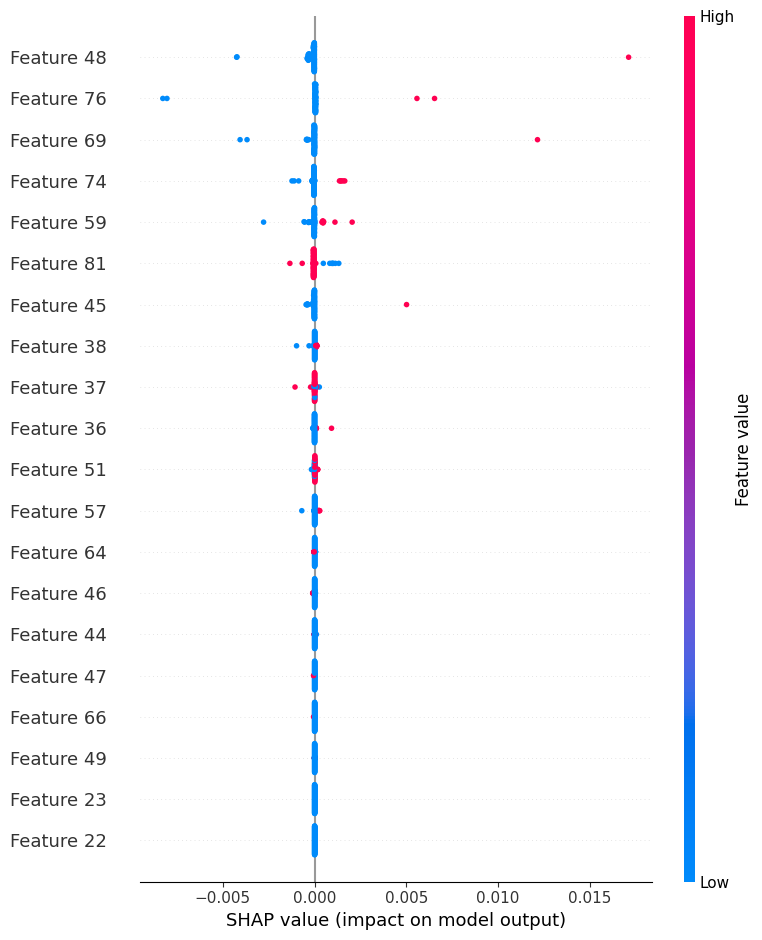

In [ ]:
shap.summary_plot(shap_values, X_test_sample)


- Feature Impact: Features with larger spreads in SHAP values (like Feature 48 and Feature 76) have a more significant impact on the model's predictions.
- Positive and Negative Influence: If the SHAP values for a feature are mostly on one side of zero, this feature tends to push predictions consistently in one direction.
- Feature Value Influence: The color gradient shows how the feature value relates to the impact. For instance, if high feature values (red) are associated with high SHAP values (positive impact), this feature increases the prediction when its value is high.

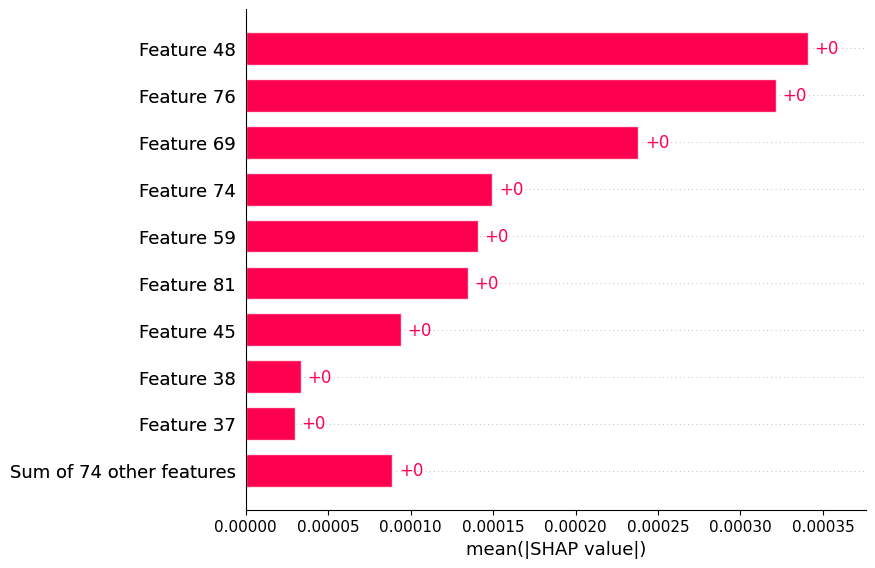

In [ ]:
shap.plots.bar(shap_values)


### Layer-wise Relevance Propagation (LRP)


In [ ]:
!pip install innvestigate


In [2]:
import innvestigate
import innvestigate.utils as iutils
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
import pickle

classModel = load_model("classifier.h5")
kddCupTrain = pickle.load(open('prepared_kddCupTrain.sav', 'rb'))
kddCupTest = pickle.load(open('prepared_kddCupTest.sav', 'rb'))

In [9]:
import tensorflow as tf
from keras.models import Model, load_model

# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Recreate the model without the softmax layer
input_layer = classModel.input
output_layer = classModel.layers[-1].output
simple_model = Model(inputs=input_layer, outputs=output_layer)

# Create an analyzer
analyzer = innvestigate.create_analyzer("lrp.z", simple_model)

# Select some samples for explanation
samples = kddCupTest[featuresList].values[:5]


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


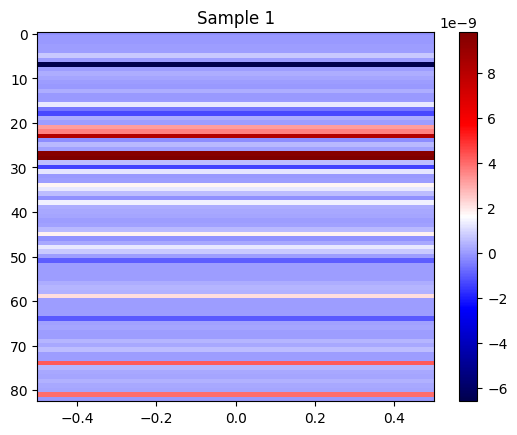

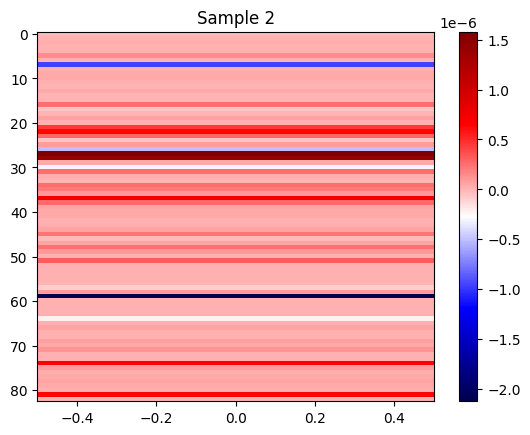

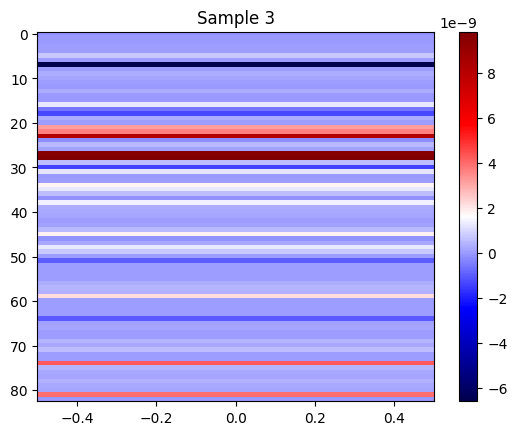

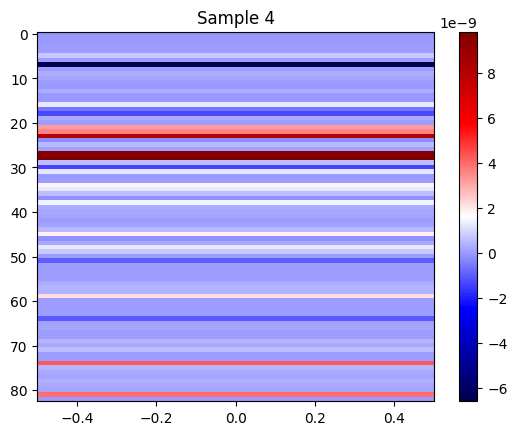

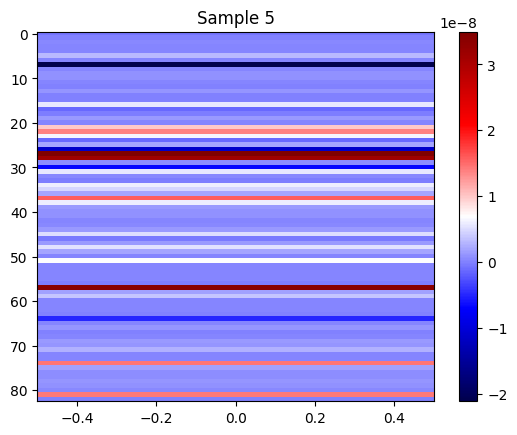

In [10]:
import sys

# Increase the recursion limit
sys.setrecursionlimit(100000)

# Apply the analyzer
analysis = analyzer.analyze(samples)

# Visualize the results
for i in range(len(samples)):
    plt.figure()
    plt.title(f"Sample {i + 1}")
    plt.imshow(analysis[i].reshape((len(featuresList), 1)), aspect='auto', cmap='seismic')
    plt.colorbar()
    plt.show()


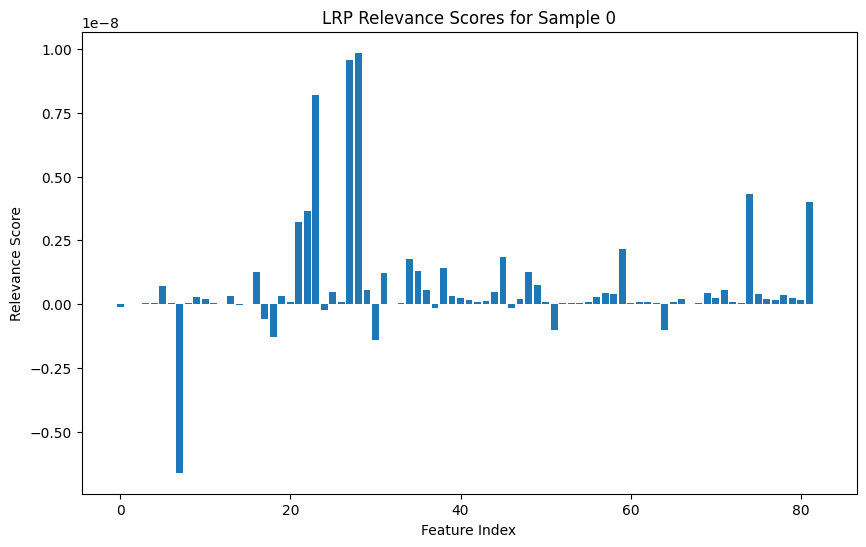

In [11]:
# For demonstration, let's take the first sample's relevance scores
relevance_scores = analysis[0]

# Plot the relevance scores as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(relevance_scores)), relevance_scores)
plt.xlabel('Feature Index')
plt.ylabel('Relevance Score')
plt.title('LRP Relevance Scores for Sample 0')
plt.show()

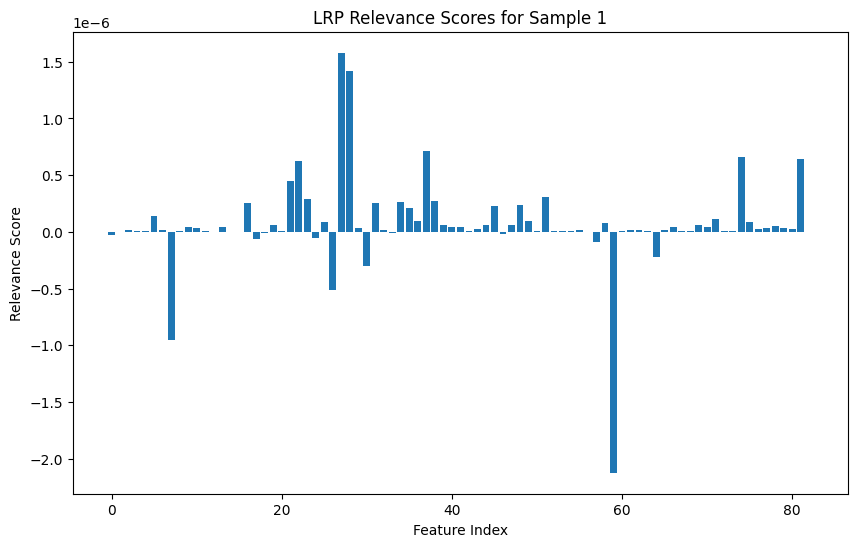

In [12]:
# For demonstration, let's take the first sample's relevance scores
relevance_scores = analysis[1]

# Plot the relevance scores as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(relevance_scores)), relevance_scores)
plt.xlabel('Feature Index')
plt.ylabel('Relevance Score')
plt.title('LRP Relevance Scores for Sample 1')
plt.show()